# Image classification using Perceptron

* Since a single perceptron could only be used for binary clssification,we consider only two classes in the first half. Eventually we will extend it to multi-class setting.
* Suppose we want to recognize whether the given image is of digit zero or not. Then the problem could be cast as binary classification.
* First: create a dataset contains the image of digit iamges written by humans.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import warnings

#sklearn imports
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import hinge_loss, ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, precision_score,recall_score,classification_report, make_scorer
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV
from pprint import pprint


## Data loading and Spliting

In [2]:
X,y= fetch_openml('mnist_784', version=1, return_X_y=True)
#it returns Data and label as pandas dataframe

The data matrix X and the respective label vector y need to be converted to the numpy array by calling a to_numpy method.

In [3]:
X=X.to_numpy()
y=y.to_numpy()

In [4]:
target_names=np.unique(y)
print('Number of samples:{0},type:{1}'.format(X.shape[0],X.dtype))
print('Number of features:{0}'.format(X.shape[1]))
print('Minimum:{0}, Maximum:{1}'.format(np.min(X),np.max(X)))
print('Number of classes:{0},type:{1}'.format(len(target_names),y.dtype))
print('Labels:{0}'.format(target_names))

Number of samples:70000,type:float64
Number of features:784
Minimum:0.0, Maximum:255.0
Number of classes:10,type:object
Labels:['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


* So, by looking at the outcome we can conclude that the each image comes with 784 features and there are such 70000 samples.
* Each feature define a pixel in the grid
* pixel range [0,255]
* Each image comes in 28X28 grid which makes 784


Standardizing the feature using MinMaxScaler preprocessing

In [5]:
X=MinMaxScaler().fit_transform(X)
print("Minimum:{0},Maximum{1}".format(np.min(X),np.max(X)))

Minimum:0.0,Maximum1.0


## Data visualization

Image are stacked as a row vector 1 X 784 and therefore must be reshaped to the matrix of size 28 x 28 to display them properly.

C:\Users\Deepak sirohiwal\AppData\Local\Temp\ipykernel_23236\1473982052.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  factor = np.int(np.sqrt(num_images))


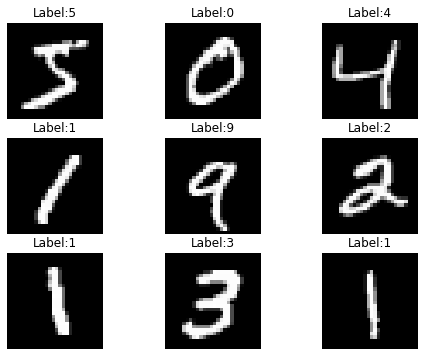

In [6]:
num_images= 9 # Choose a square number
factor = np.int(np.sqrt(num_images))
fig,ax=plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset=0
for i in range(factor):
    index=idx_offset+i*(factor)
    for j in range(factor):
        ax[i,j].imshow(X[index+j].reshape(28,28),cmap='gray')
        ax[i,j].set_title('Label:{0}'.format(str(y[index+j])))
        ax[i,j].set_axis_off()

## Data spliting

* Spliting data into testing and training data 
* 60,000 samples for training and 10,000 for testing
* Since the sample in the data set are already shuffled, we need not be shuffle it again. Therefore using train_test_split() may be skipped

In [7]:
x_train,x_test,y_train,y_test= X[:60000],X[60000:],y[:60000],y[60000:]

Checking if the dataset are balanced

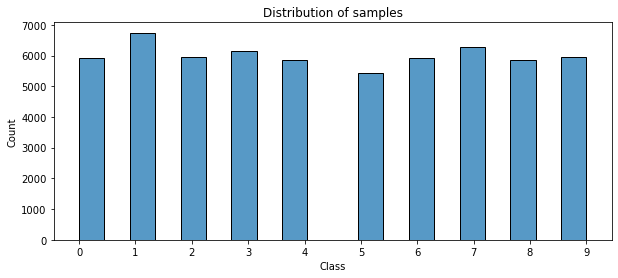

In [8]:
plt.figure(figsize=(10,4))
sns.histplot(data=np.int8(y_train),binwidth=0.45,bins=11)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9],labels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of samples')
plt.show()

## Binary Classification: 0-Detector

### Modifying Labels
* 0 will be changed to 1 and all other labels(1-9) will be changed to -1

In [11]:
#initialize new variable name with all -1
y_train_0=-1*np.ones((len(y_train)))
y_test_0=-1*np.ones((len(y_test)))

#find indices of digit 0 image
indx_0= np.where(y_train=='0') #coz original data is of string type

y_train_0[indx_0]=1 #change class to 1 where digit is 0 in training label

indx_0=np.where(y_test=='0')
y_test_0[indx_0]=1

'''
after this all the labels with 0 changes to class 1 and rest to -1.
'''

'\nafter this all the labels with 0 changes to class 1 and rest to -1.\n'

### Baseline models

1. Count number of samples per class.
2. The model always outputs the class which has highest number of samples.
3. Then calculate the accuracy of the baseline model.

In [12]:
num_pos=len(np.where(y_train_0==1)[0])
num_neg= len(np.where(y_train_0==-1)[0])

print(num_pos,num_neg)

5923 54077


In [13]:
base_clf= DummyClassifier(strategy='most_frequent')


In [14]:
base_clf.fit(x_train,y_train_0)
print("Training accuracy:{0:.2f}".format(base_clf.score(x_train,y_train_0)))
print("Training accuracy:{0:.2f}".format(base_clf.score(x_test,y_test_0)))


Training accuracy:0.90
Training accuracy:0.90


The model would have predicted 54077 sample correctly just by outputing -1 for all the input samples. Therefore the accuracy will be 54077/60000=90.12%

### Perceptron model

In [15]:
bin_clf=Perceptron(max_iter=100,random_state=1729)

Training and prediction

In [16]:
bin_clf.fit(x_train,y_train_0)
print('Dimention of weight w: {0}'.format(bin_clf.coef_.shape))
print('Bias:{0}'.format(bin_clf.intercept_))
print('The loss function: {0}'.format(bin_clf.loss_function_))

Dimention of weight w: (1, 784)
Bias:[-108.]
The loss function: <sklearn.linear_model._sgd_fast.Hinge object at 0x000002385CEDF710>


In [17]:
y_hat_train_0=bin_clf.predict(x_train)
print('Training accuracy:',bin_clf.score(x_train,y_train_0))
print('Test accuracy', bin_clf.score(x_test,y_test_0))

Training accuracy: 0.99095
Test accuracy 0.989


### Displaying predictions

C:\Users\Deepak sirohiwal\AppData\Local\Temp\ipykernel_23236\2193411666.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  factor = np.int(np.sqrt(num_images))


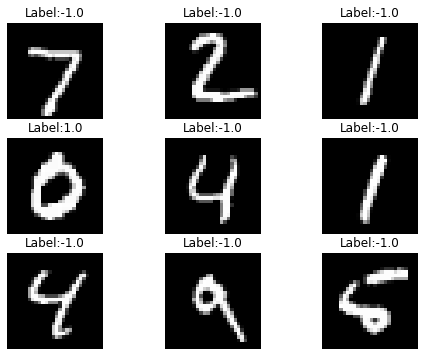

In [18]:
y_hat_test_0=bin_clf.predict(x_test)
num_images= 9 # Choose a square number
factor = np.int(np.sqrt(num_images))
fig,ax=plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset=0
for i in range(factor):
    index=idx_offset+i*(factor)
    for j in range(factor):
        ax[i,j].imshow(x_test[index+j].reshape(28,28),cmap='gray')
        ax[i,j].set_title('Label:{0}'.format(str(y_hat_test_0[index+j])))
        ax[i,j].set_axis_off()

Display image of positive class

In [21]:
index_0=np.where(y_test_0==1) #digit zero


C:\Users\Deepak sirohiwal\AppData\Local\Temp\ipykernel_23236\3669091268.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  factor = np.int(np.sqrt(num_images))


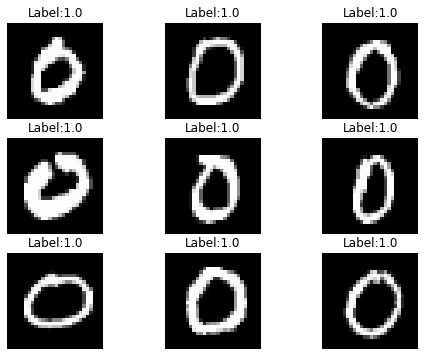

In [20]:
zeroImgs=x_test[index_0[0]]
zeroLabels=y_hat_test_0[index_0[0]]

num_images= 9 # Choose a square number
factor = np.int(np.sqrt(num_images))
fig,ax=plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset=0
for i in range(factor):
    index=idx_offset+i*(factor)
    for j in range(factor):
        ax[i,j].imshow(zeroImgs[index+j].reshape(28,28),cmap='gray')
        ax[i,j].set_title('Label:{0}'.format(str(zeroLabels[index+j])))
        ax[i,j].set_axis_off()

It seems that there are a significant number of images that are correctly classified. Lets see how many?

In [26]:
num_misclassified= np.count_nonzero(zeroLabels==-1)
num_correctpred=len(zeroLabels)-num_misclassified #zerolabels are the predicted labels for the digit 0 it may contains 1 or -1
accuracy= num_correctpred/len(zeroLabels)
print(accuracy)

0.9193877551020408


### Better Evaluation metrics

* Accuracy alone to measure performance of the model is not suitable(esspecially for the imbalanced datasets).

#### Confusion Matrix

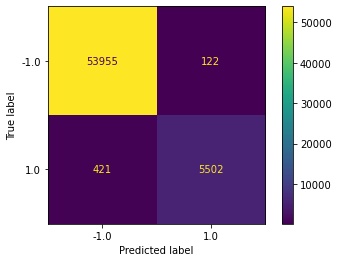

In [27]:
y_hat_train_0= bin_clf.predict(x_train) #perceptron
cm_display= ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_0,values_format='.5g')
plt.show()

False Positive=122

False Negative=421

#### Precision and Recall


In [34]:
clf_report= classification_report(y_train_0,y_hat_train_0,output_dict=True)

In [43]:
print('Precision: ',clf_report['1.0']['precision'])
print('Recall: ', clf_report['1.0']['recall'])
print('Accuracy :', clf_report['accuracy'])

Precision:  0.9783072546230441
Recall:  0.9289211548201924
Accuracy : 0.99095


* We have precision of 0.98, still want to make it better.
* checking hyper-parameters

### Cross Validation

* Perceptron does not have many hyperparameter to tweeks other than learning rate.
* For the moment, we set the learning rate to default value. we use GridSearchCV to finf the better value for the learning rate. default learning rate=0.0001

In [44]:
scores= cross_validate(bin_clf,x_train,y_train_0, cv=5,
scoring=['precision','recall','f1'],
return_estimator=True)

pprint(scores)

{'estimator': [Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729)],
 'fit_time': array([0.86015558, 1.76939726, 1.13346481, 1.07427764, 1.21417785]),
 'score_time': array([0.02989364, 0.02787685, 0.03890181, 0.03294134, 0.03124285]),
 'test_f1': array([0.95238095, 0.91666667, 0.94915254, 0.94117647, 0.95091763]),
 'test_precision': array([0.95890411, 0.98828125, 0.95319149, 0.95090439, 0.96200345]),
 'test_recall': array([0.94594595, 0.85472973, 0.94514768, 0.93164557, 0.94008439])}


The cross validation score for all 5 folds are slightly different.
* Compute the average and standard deviation of scores for all three metrics on (k=5) folds to measure the generalization.

In [46]:
print('f1, avg:{0:.2f}, std:{1:.3f}'.format(scores['test_f1'].mean(),scores['test_f1'].std()))
print('f1, avg:{0:.2f}, std:{1:.2f}'.format(scores['test_precision'].mean(),scores['test_precision'].std()))
print('f1, avg:{0:.2f}, std:{1:.2f}'.format(scores['test_recall'].mean(),scores['test_recall'].std()))


f1, avg:0.94, std:0.013
f1, avg:0.96, std:0.01
f1, avg:0.92, std:0.03


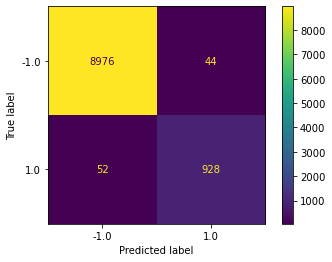

In [54]:
bin_clf=scores['estimator'][0] #best estimator , got the best F1 score of all the folds
y_hat_test_0= bin_clf.predict(x_test)
sm_display=ConfusionMatrixDisplay.from_predictions(y_test_0,y_hat_test_0,values_format='.5g')

In [53]:
print('Precision %.2f'%precision_score(y_test_0,y_hat_test_0))
print('Recall %.2f'%recall_score(y_test_0,y_hat_test_0))

Precision 0.95
Recall 0.95


Prediction for each example

In [55]:
y_hat_train_0= cross_val_predict(bin_clf,x_train,y_train_0, cv=5)


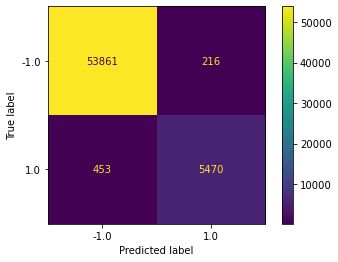

In [56]:
cm_display=ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_0, values_format='.5g')
plt.show()

In [57]:
clf_report= classification_report(y_train_0,y_hat_train_0,output_dict=True)

In [58]:
print('Precision: ',clf_report['1.0']['precision'])
print('Recall: ', clf_report['1.0']['recall'])
print('Accuracy :', clf_report['accuracy'])

Precision:  0.9620119591980303
Recall:  0.9235184872530812
Accuracy : 0.98885


In [60]:
pprint(clf_report)

{'-1.0': {'f1-score': 0.9938279008404757,
          'precision': 0.9916596089406047,
          'recall': 0.9960056955822253,
          'support': 54077},
 '1.0': {'f1-score': 0.9423722973555001,
         'precision': 0.9620119591980303,
         'recall': 0.9235184872530812,
         'support': 5923},
 'accuracy': 0.98885,
 'macro avg': {'f1-score': 0.9681000990979879,
               'precision': 0.9768357840693175,
               'recall': 0.9597620914176532,
               'support': 60000},
 'weighted avg': {'f1-score': 0.9887483751831171,
                  'precision': 0.9887328917835169,
                  'recall': 0.98885,
                  'support': 60000}}


## Precision/Recall Tradeoff


* Often we have to make a tradeoff between recall and precision
* and it is depend on the problem.

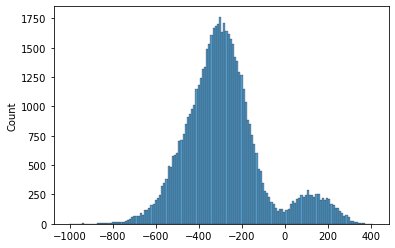

In [63]:
bin_clf=Perceptron(random_state=1729)
bin_clf.fit(x_train,y_train_0)
y_scores= bin_clf.decision_function(x_train)
sns.histplot(np.sort(y_scores))
plt.show()

* Suppose threshold takes the value of -600, then all samples having score greater than -600 is set to 1(Positive label) and less than it is set to -1.
* Therefore the number of False positive will be increase. This will in turn reduce the  precision score to a greater extent.
* If threshold takes the value of, say 400. Then the number of false negative will be increased and hence recall will  reduce to greater extend.

Now we will vary the threshold and calculte precision and recall.

In [64]:
precisions, recalls, thresholds= precision_recall_curve(y_train_0,y_scores, pos_label=1)

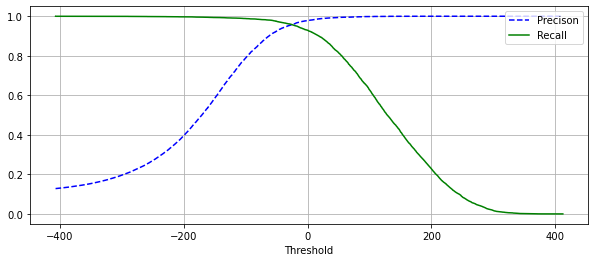

In [65]:
plt.figure(figsize=(10,4))
plt.plot(thresholds,precisions[:-1],"b--",label="Precison")
plt.plot(thresholds, recalls[:-1],"g-",label='Recall')
plt.xlabel('Threshold')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

In [75]:
idx_th=np.where(np.logical_and(thresholds>0, thresholds<1))
print('precision for zero threshold:', precisions[idx_th[0][0]])

precision for zero threshold: 0.9783072546230441


### The ROC curve

In [76]:
from sklearn.metrics import roc_curve


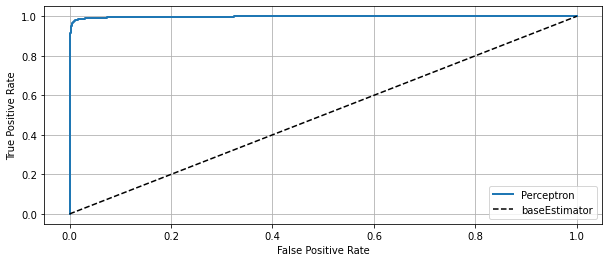

In [77]:
fpr,tpr, thresholds=roc_curve(y_train_0,y_scores)
plt.figure(figsize=(10,4))
plt.plot(fpr,tpr,linewidth=2,label='Perceptron')
plt.plot([0,1],[0,1],'k--',label='baseEstimator')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

## Multiclass Classifier (One Vs All)

* To address multiclass problem we will use LabelBinarizer to fit each binary classifier

In [78]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import LabelBinarizer

In [79]:
clf=Perceptron(random_state=1729)

In [80]:
#Let's use label binarizer just to see the encoding
y_train_ovr=LabelBinarizer().fit_transform(y_train)
for i in range(10):
    print('{0}:{1}'.format(y_train[i],y_train_ovr[i]))

5:[0 0 0 0 0 1 0 0 0 0]
0:[1 0 0 0 0 0 0 0 0 0]
4:[0 0 0 0 1 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
9:[0 0 0 0 0 0 0 0 0 1]
2:[0 0 1 0 0 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
3:[0 0 0 1 0 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
4:[0 0 0 0 1 0 0 0 0 0]


In [81]:
clf.fit(x_train,y_train)

Perceptron(random_state=1729)

* The API internally created 10 binary classifiers, converted labels to binary sparse matrix and trained them with binarized labels.
* During the inference time, the input will be passed through all these 10 classifiers and the highest score among the ouput from the classifiers will be considered as the predicted class.


In [82]:
print('Shape of weight matrix:{0} and bias vector:{1}'.format(clf.coef_.shape, clf.intercept_.shape))

Shape of weight matrix:(10, 784) and bias vector:(10,)


* Weight matrix is 10 X 784, where each row is a single binary classifier.
* The class of a perceptron that outputs the maximum score for the input is considered as the predicted class.

confidence score for the sample.

In [83]:
scores=clf.decision_function(x_train[6].reshape(1,-1))
print(scores)
print('The predicted class: ',np.argmax(scores))

[[-631.88492118  154.366213    -65.23234141  -90.95338716 -189.29568627
  -137.14385236  -99.64604383 -159.09859285 -136.86391388 -199.26120723]]
The predicted class:  1


In [84]:
print('Predicted output:\n')
print(clf.predict(x_train[0].reshape(1,-1)))

Predicted output:

['5']


In [85]:
y_hat=clf.predict(x_train)

In [87]:
print(classification_report(y_train,y_hat))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      5923
           1       0.94      0.98      0.96      6742
           2       0.89      0.90      0.90      5958
           3       0.86      0.87      0.87      6131
           4       0.89      0.94      0.91      5842
           5       0.81      0.88      0.85      5421
           6       0.92      0.97      0.94      5918
           7       0.91      0.94      0.92      6265
           8       0.92      0.77      0.84      5851
           9       0.92      0.82      0.87      5949

    accuracy                           0.90     60000
   macro avg       0.90      0.90      0.90     60000
weighted avg       0.91      0.90      0.90     60000



Confusion matrix and relate it with report above.

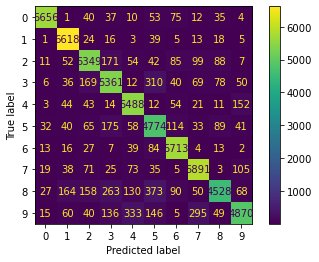

In [88]:
cm_display=ConfusionMatrixDisplay.from_predictions(y_train,y_hat,values_format='.5g')

Conclusion:
* digit 2 is often confused with 3 and vice versa. 
* digit 5 with 6
* 7 with 9 and 4 with 9 


## Iteration vs Loss Curve

 Plotting Iteration Vs Loss curve with the Partial_fit method.

In [90]:
iterations=100
bin_clf1=Perceptron(max_iter=1000, random_state=2094)
Loss_clf1=[]
for i in range(iterations):
    bin_clf1.partial_fit(x_train,y_train_0,classes=np.array([-1,1]))
    y_hat_o=bin_clf1.decision_function(x_train)
    Loss_clf1.append(hinge_loss(y_train_0,y_hat_o))


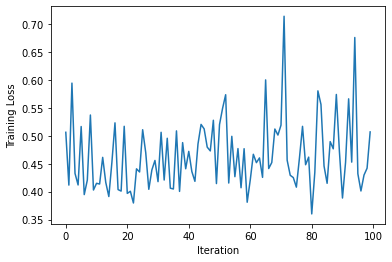

In [91]:
plt.figure()
plt.plot(np.arange(iterations),Loss_clf1)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.show()

### GridSearchCV

* So far we didn't do any hyperparameter tuning. We accepted the default value for learning rate of the Perceptron class.
* Now, let us search for a better learning rate using GridSearchCV.
* No matter what the learning rate is, the loss will never converge to zero as the clases are not linearly separable.

In [92]:
scoring=make_scorer(hinge_loss,greater_is_better=False)
lr_grid=[1/2**n for n in range(1,6)]
bin_clf_gscv=GridSearchCV(Perceptron(),param_grid={"eta0":lr_grid},scoring=scoring,cv=5)
bin_clf_gscv.fit(x_train,y_train_0)

GridSearchCV(cv=5, estimator=Perceptron(),
             param_grid={'eta0': [0.5, 0.25, 0.125, 0.0625, 0.03125]},
             scoring=make_scorer(hinge_loss, greater_is_better=False))

In [94]:
pprint(bin_clf_gscv.cv_results_)

{'mean_fit_time': array([1.08505921, 1.00446744, 1.02347956, 0.81133089, 0.78738608]),
 'mean_score_time': array([0.02066355, 0.01476202, 0.01592026, 0.01498685, 0.02500663]),
 'mean_test_score': array([-0.0285    , -0.0285    , -0.02643333, -0.03066667, -0.0421    ]),
 'param_eta0': masked_array(data=[0.5, 0.25, 0.125, 0.0625, 0.03125],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'eta0': 0.5},
            {'eta0': 0.25},
            {'eta0': 0.125},
            {'eta0': 0.0625},
            {'eta0': 0.03125}],
 'rank_test_score': array([2, 2, 1, 4, 5]),
 'split0_test_score': array([-0.02166667, -0.02166667, -0.02166667, -0.02166667, -0.02166667]),
 'split1_test_score': array([-0.0395, -0.0395, -0.0395, -0.0395, -0.0395]),
 'split2_test_score': array([-0.02816667, -0.02816667, -0.02816667, -0.02816667, -0.02816667]),
 'split3_test_score': array([-0.023     , -0.023     , -0.023     , -0.04416667, -0.04416667]),
 

we can conclude that the best learning rate is 0.125

In [95]:
iterations=100
Loss=[]
best_bin_clf= Perceptron(max_iter=1000,random_state=2094, eta0=0.125)
for i in range(iterations):
    best_bin_clf.partial_fit(x_train,y_train_0, classes=np.array([1,-1]))
    y_hat_0=best_bin_clf.decision_function(x_train)
    Loss.append(hinge_loss(y_train_0,y_hat_0))


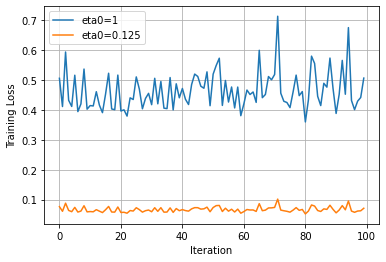

In [96]:
plt.figure()
plt.plot(np.arange(iterations),Loss_clf1,label='eta0=1')
plt.plot(np.arange(iterations),Loss,label='eta0=0.125')
plt.grid(True)
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.show()

In [98]:
#insted of instatiating a Perceptron class with a new learning rate and re-train the model
# use best_estimator 
best_bin_clf=bin_clf_gscv.best_estimator_

In [99]:
y_hat_train_0=bin_clf.predict(x_train)
print(classification_report(y_train_0,y_hat_train_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99     54077
         1.0       0.98      0.93      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000

